In [98]:
%pip install python_speech_features

In [127]:
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
import python_speech_features as ph
from python_speech_features import mfcc
from python_speech_features import logfbank
from python_speech_features import sigproc
from scipy.fftpack import dct
from scipy.signal import get_window
import scipy.fftpack as fft
import numpy as np


(155, 551)
(1025, 68) (155, 26)


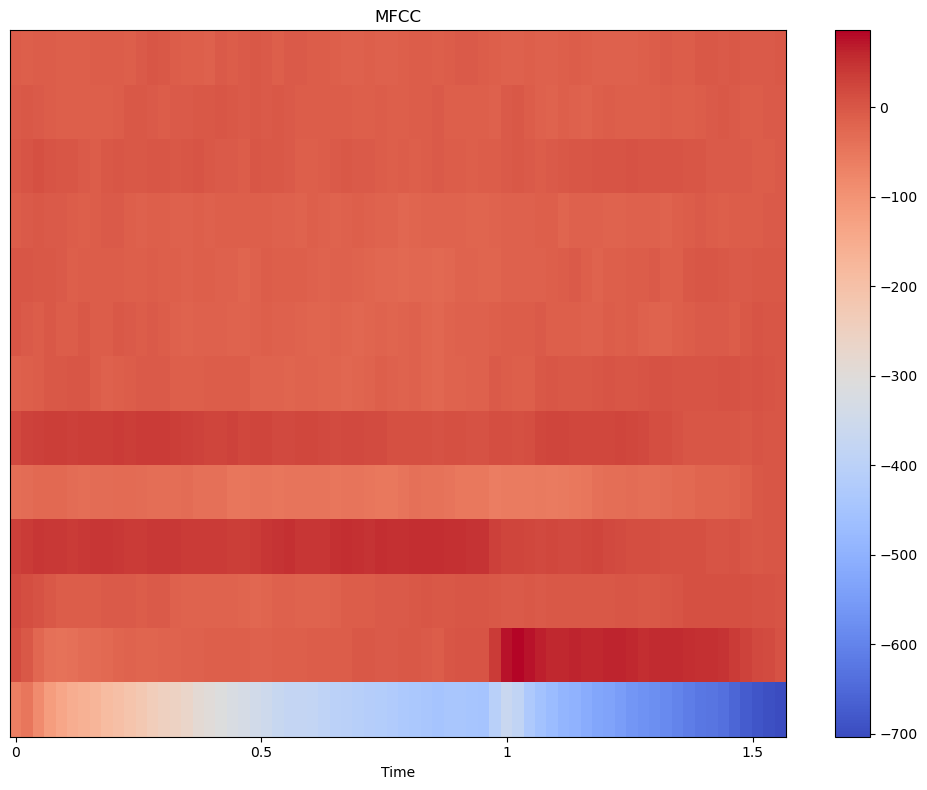

In [174]:
x, sr = librosa.load("c-note.wav")
fr_length = 0.025*sr
step = 0.01*sr
#mfccExtract = ph.features.mfcc(x, sr, winfunc=np.hamming)
mfcc_feat = ph.mfcc(x,sr)
fbank_feat = ph.logfbank(x,sr)
s = ph.sigproc.framesig(x,fr_length,step)
print(s.shape)
mfccs = librosa.feature.mfcc(y=x, sr=sr,n_mfcc=13)
spectogram = librosa.feature.melspectrogram(y=x, sr=sr)
ff = librosa.stft(x)
print(ff.shape, fbank_feat.shape)

plt.figure(figsize=(10, 8))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


# Compute MFCC features
#mfccs = librosa.feature.mfcc(y=x, sr=sr,hop_length=512,n_mfcc=13)



In [129]:
def load_signal(signal):
    samplerate, audio = scipy.io.wavfile.read(signal) 
    return samplerate, audio 
    
def pre_emphasis(audio, alpha=0.97):
    return np.append(audio[0], audio[1:] - alpha * audio[:-1])

samplerate, audio = load_signal("c-note.wav")
t  = np.linspace(0, len(audio)/samplerate, len(audio))
frame_length = 0.025
frame_step = 0.01
numbers_filters = 26
fft_coeff = 512
signal_emphasis = pre_emphasis(audio)

C:\Users\nushi\AppData\Local\Temp\ipykernel_13204\790312095.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, audio = scipy.io.wavfile.read(signal)


C:\Users\nushi\AppData\Local\Temp\ipykernel_13204\1892346921.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, audio = scipy.io.wavfile.read(signal)


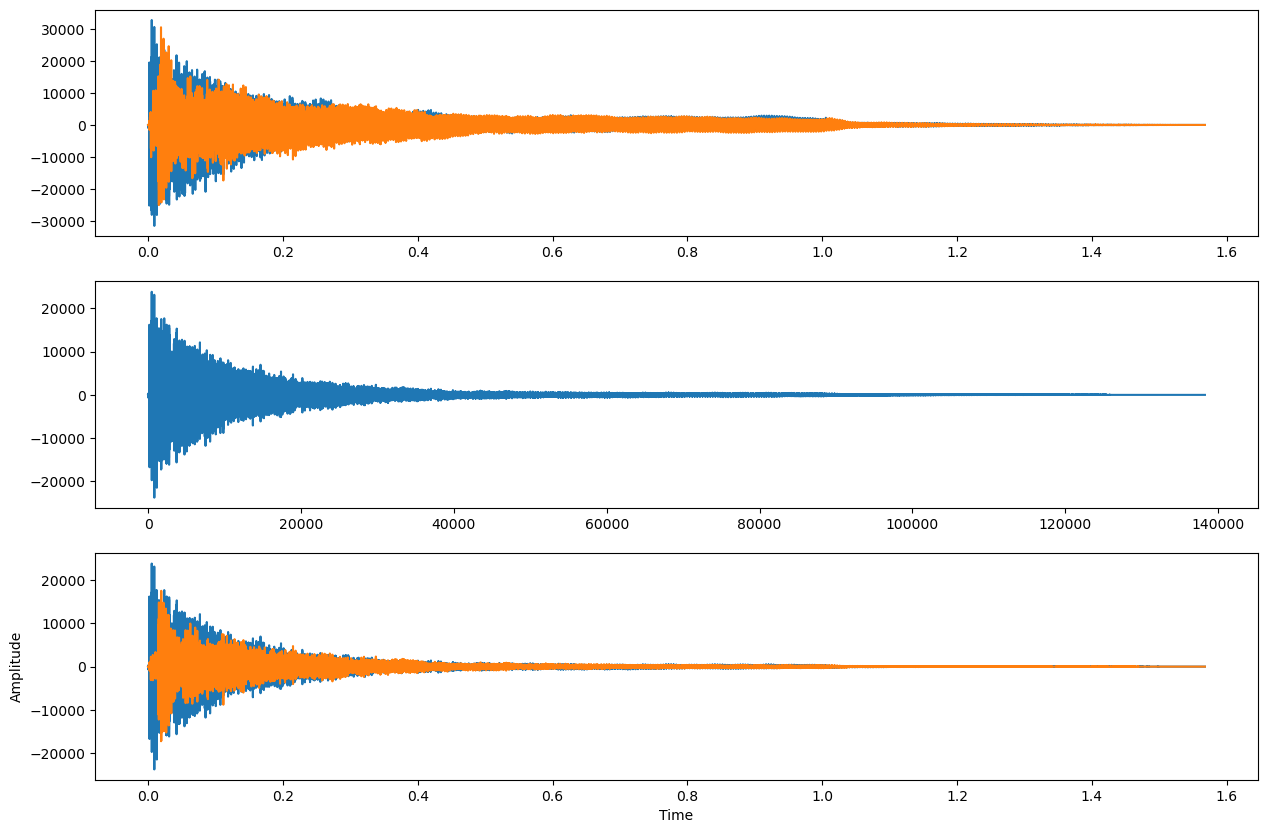

In [3]:
samplerate, audio = load_signal("c-note.wav")
t  = np.linspace(0, len(audio)/samplerate, len(audio))
frame_length = 0.025
frame_step = 0.01
numbers_filters = 26
fft_coeff = 512
signal_emphasis = pre_emphasis(audio)

plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(t, audio)
plt.subplot(312)
plt.plot(signal_emphasis)
plt.subplot(313)
plt.plot(t, pre)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


In [154]:
def frame_audio(audio, FFT_size, hop_size, sample_rate):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]    
    return frames
 
def audio_frames(audio, sample_rate, frame_length, frame_step):    
    signal_length = len(audio)
    frame_samples_length = frame_length * sample_rate 
    frames_step_samples_length = frame_step * sample_rate
    num_frames = np.ceil((signal_length - frame_samples_length)/frames_step_samples_length) + 1 # +one frame left last without step
 
    n = np.array([np.arange(0, int(frame_samples_length),dtype='int64') for i in np.arange(0, int(num_frames),dtype='int64')]) # all samples/frame for every frame
    m_M = np.array([(np.arange(0, int(num_frames),dtype='int64'))*int(frames_step_samples_length) for i in np.arange(0, int(frame_samples_length),dtype='int64')]).T # from equation m*M for every frame, array should be transformed, this is 
    all_frames_x = n + m_M

    length_diff = int(num_frames * frames_step_samples_length + frame_samples_length) - signal_length
    zeros_padding = np.zeros(length_diff)
    new_audio = np.append(audio, zeros_padding)   #if we don't have equal length we add zeros in the end. This is because each frame overlap with frame_step
    audio_frames = new_audio[all_frames_x] # the audio sliced on segments/frames    

    return audio_frames
 
def window(framed_audio, frame_length):    
    hamm_w = np.array([0.54 - 0.46*np.cos((np.pi*2*i)/(frame_length-1)) for i in np.arange(0,frame_length-1)]) # to check N or N-1
    audio_framed_window = np.array(hamm_w * framed_audio) #hamming window (vector) multiply by each frame
    return audio_framed_window

def hamm(framed_audio, frame_length):
    hamming_window = get_window("hamming", frame_length, fftbins=True)
    return framed_audio * hamming_window

(314, 512) (313, 1102)


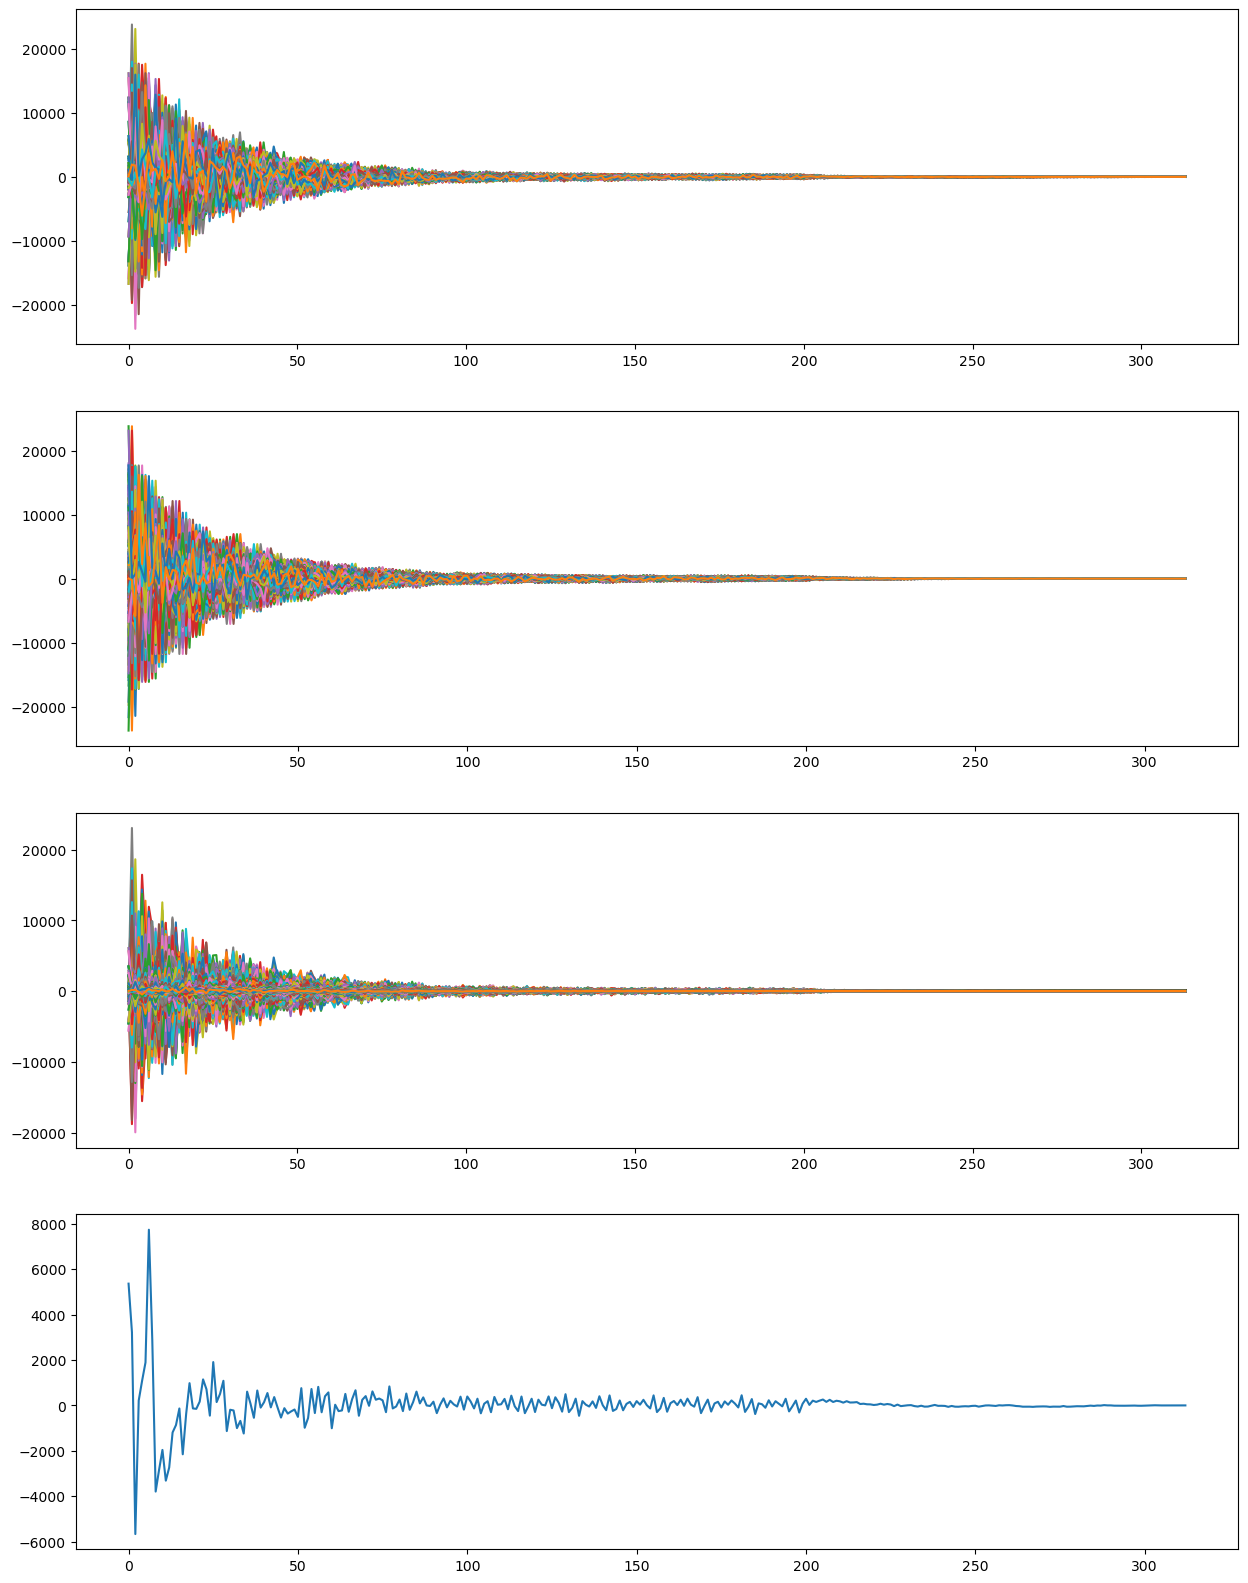

In [155]:
frames_per_web = frame_audio(signal_emphasis,fft_coeff,frame_step*1000, samplerate)
frame_audio_custom = audio_frames(signal_emphasis, samplerate, frame_length, frame_step)
print(frames_per_web.shape, frame_audio_custom.shape)

ham_1 = np.hamming(fft_coeff)
frames_1 = np.dot(frames_per_web, ham_1)

ham_2 = np.hamming(frame_length*samplerate)
frames_2 = np.dot(frame_audio_custom, ham_2)

windowing_step = window(frame_audio_custom, frame_length * samplerate)
win_hamm = hamm(frames_per_web, fft_coeff)

plt.figure(figsize = (15,20))
plt.subplot(411)
plt.plot(frames_per_web)
plt.subplot(412)
plt.plot(frame_audio_custom)
plt.subplot(413)
plt.plot(win_hamm)
plt.subplot(414)
plt.plot(frames_2)
plt.show()

In [144]:
# def stft_power_spec(window_audio, frame_length, fft_coeff):    
#     audio_length = len(window_audio)
#     print(window_audio.shape)
#     x_k = []
 
#     for w in np.arange(0, audio_length):     #314
#         sftf_frames = []
#         for c in np.arange(1, (fft_coeff/2+1)+1):  #258
#             stft = 0
#             for n in np.arange(0, len(window_audio[1])): 
#                 stft += window_audio[w, n] * np.exp((-2j * np.pi * c * n) / frame_length)
#             sftf_frames.append(stft)
#         x_k.append(sftf_frames)
   
#     x_k = np.array(x_k)
#     print(x_k)
#    # power_spec = np.square(np.abs(x_k))/frame_length # frame length or fft_coeff ????
#     #print(power_spec.shape)
#     return x_k

def stft_power2(window_audio, frame_length, fft_coeff):    
    
    # Compute FFT for each channel
    audio_winT = np.transpose(window_audio)
    audio_fft = np.empty((int(1 + fft_coeff // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')
    
    for n in range(audio_fft.shape[1]):
        audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]
    
    audio_fft = np.transpose(audio_fft)
   
    return np.square(np.abs(audio_fft))/frame_length

def fft_proba(frames, nfft):
    return np.absolute(np.fft.rfft(frames, nfft)) 

def power_sp(fft,frame_length):
    return np.square(fft)/frame_length

(313, 257) (313, 257) (313, 257)


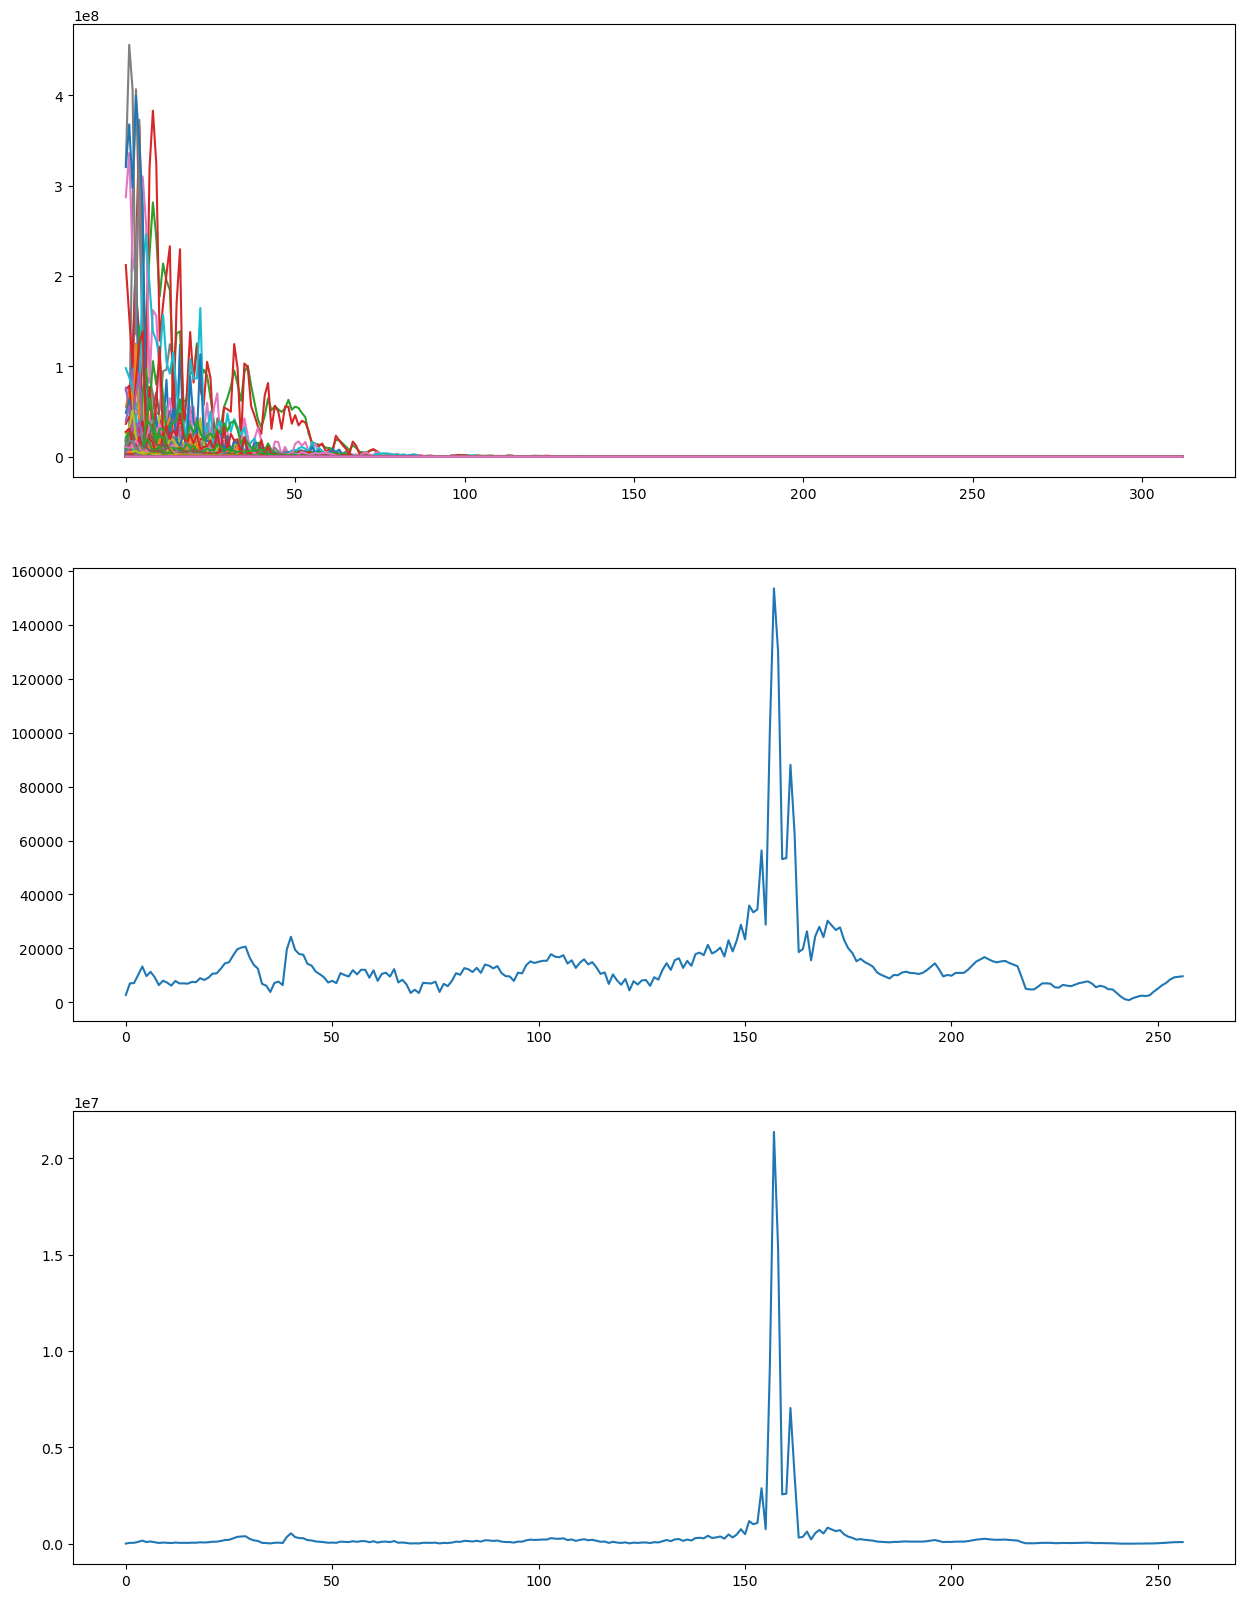

In [145]:
#stft_ps = stft_power_spec(win_hamm, frame_length * samplerate, fft_coeff) 
fft_f = stft_power2(windowing_step, frame_length * samplerate, fft_coeff) 

fft_check = fft_proba(frames_1, fft_coeff)
ps_2 =  power_sp(ps_for_check,frame_length * samplerate)

print(ps.shape, fft_f.shape, fft_for_check.shape)
plt.figure(figsize=(15,20))
plt.subplot(311)
plt.plot(fft_f)
plt.subplot(312)
plt.plot(fft_check)
plt.subplot(313)
plt.plot(ps_2)
plt.show()

In [146]:
def h_mel_transform_filters(samplerate, numbers_filters): # convert Hz to Mel and divide on the triangularers Mel filters, usually they are 26 filters
    mels = np.linspace(0, 2595*np.log10(1+ (samplerate/2)/700), (numbers_filters+2)) # low frequency = 0, high - samplerates/2 num fil +2
    return mels
 
def mel_frequency_convert(mels): # convert again Mel to Hz 
    frequency_mel = (700 * (10**(mels/2595) - 1))
    return frequency_mel
 
def mel_filterbanks(numbers_filters, frequency_mel, power_spectrum, samplerate, fft_coeff):
    f_bins = (np.floor(((fft_coeff+1)*frequency_mel)/samplerate))
    
    mel_filters = np.zeros(( int(fft_coeff/2 +1),numbers_filters))
  
    for m in np.arange(1, numbers_filters+1):        
        for k in np.arange(int(f_bins[m-1]), int(f_bins[m])):
            mel_filters[k,m-1] = ((k - f_bins[m-1])/(f_bins[m]-f_bins[m-1]))    
        for k in np.arange( int(f_bins[m]), int(f_bins[m+1])+1):
            mel_filters[k,m-1] = ((f_bins[m+1]-k)/(f_bins[m+1] - f_bins[m]))
 
    mel_filters = mel_filters.reshape(int(fft_coeff/2 +1),numbers_filters)
    return mel_filters
 
def logairtm_filt(mel_filters, power_spectrum):
    EPS = 1e-10
    matrix = np.dot(power_spectrum, mel_filters)
    logaritm = np.where(matrix != 0, np.log10(matrix), EPS)   
    return logaritm

def get_filter_points(fmin, mel_filter_num, FFT_size, sample_rate):
   
    fmax_mel =2595*np.log10(1+ (sample_rate/2)/700)
  
    mels = np.linspace(0, fmax_mel, num=mel_filter_num+2)
    freqs = mel_frequency_convert(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters
 

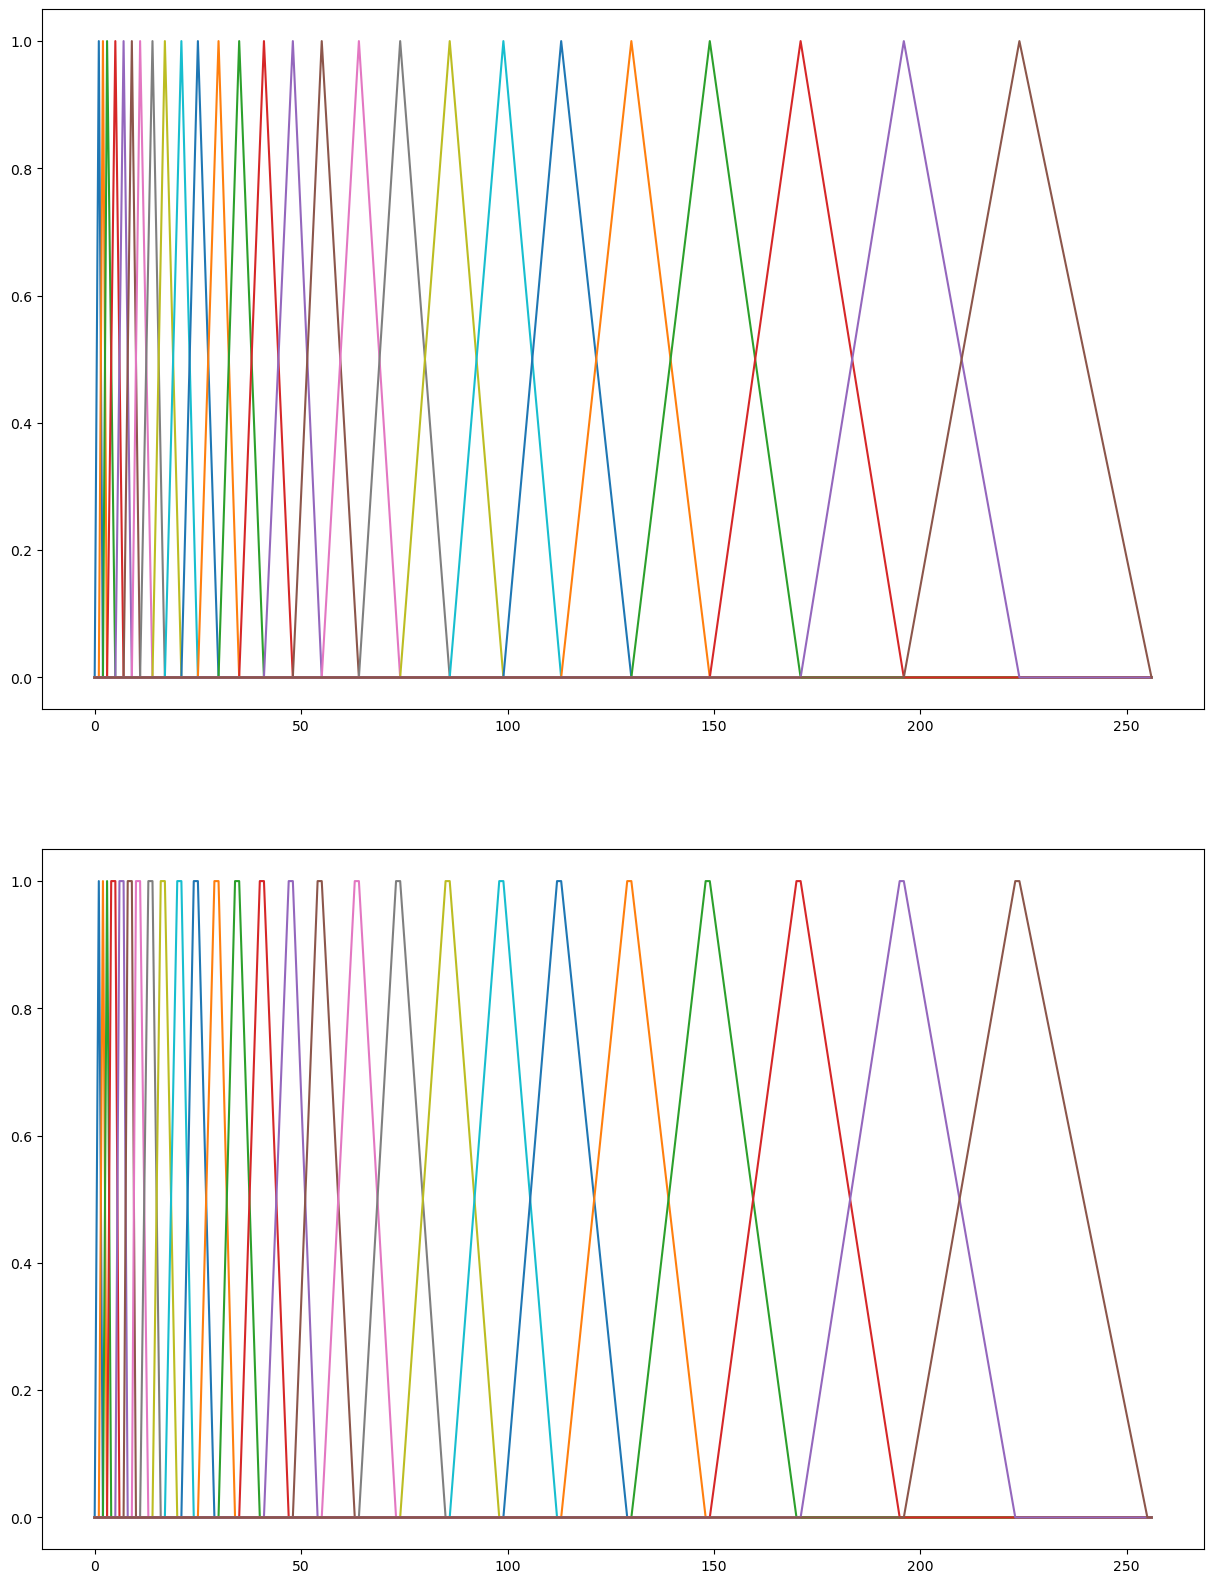

In [147]:
mel_transform = h_mel_transform_filters(samplerate, numbers_filters)
mel_frequency = mel_frequency_convert(mel_transform)
mel_filterbanks_customs = mel_filterbanks(numbers_filters, mel_frequency, ps, samplerate, fft_coeff)
logairtm_filters = logairtm_filt(mel_filterbanks_customs ,ps_2)

filter_points, mel_freqs = get_filter_points(0, numbers_filters, fft_coeff, samplerate)
filters = get_filters(filter_points, fft_coeff)
logaritm_web = logairtm_filt(filters.T, ps_2)

plt.figure(figsize=(15,20))
plt.subplot(211)
plt.plot(mel_filterbanks_customs)
plt.subplot(212)
plt.plot(filters.T)
plt.show()

In [150]:
def mels(log_f, mels_num):
    l = len(log_f) #156
    ss = np.ones((mels_num,l))
    # nums = (np.arange(0,l)*np.pi)/2*l
    # for n in range(0, mels_num):
    #     ss[n,:] = np.cos(n*(2*nums+1))
   
    # coeff = np.dot(proba_mel, log_f)
    # print(coeff)
    for n in range(0, mels_num):
        ss[n,:] *= (np.cos(np.pi*n*(2*n - 1)/2*mels_num))
        # mel_f = np.sum([log_f[m] * (np.cos(np.pi*m*(2*n - 1)/2*mels_num)) for m in np.arange(0, l)],axis=0)
        # print(mel_f)
        #ss[n] *= mel_f
        #print(ss.shape)
        #ss = np.sum(ss, axis=0)
        #proba_mel[n] *= ss
    
        # for m in np.arange(0,l):
        #     cos_coeff[:,m] = np.cos(n*(2*m-1)*np.pi/2*mels_num) 
    filters = ss@log_f
       
    return ss
    
# def compute_mfcc(logairtm_filt, num_ceps=13): # само за проба 
#     #mfcc = dct(logairtm_filt, type=2, axis=1, norm='ortho')[:, :num_ceps]
#     mfcc_num = np.preprocessing.dsp.DCT(logairtm_filt, orthonormal=True)
#     mffc_2 = scipy.fftpack.dct(logairtm_filt, type=2, n=None, norm=None, overwrite_x=False)
#     return mffc_2
    
def dct_filters_basis(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

def dct_mfcc(basis, audio):
    return np.dot(audio.T,basis)

(26, 13) (26,) (13, 314)


TypeError: Invalid shape (26,) for image data

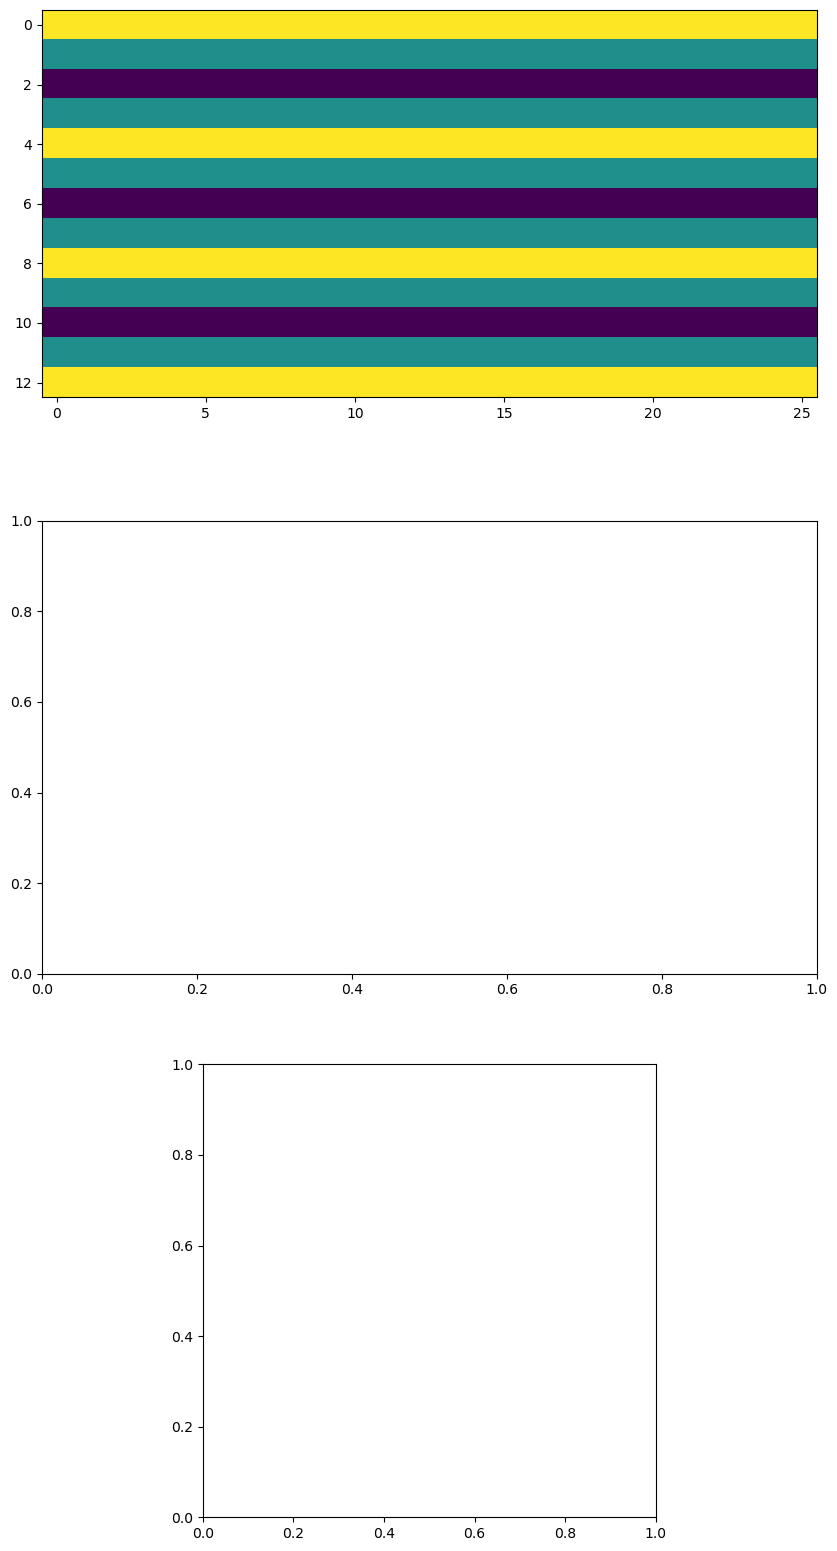

In [151]:
dct_web = dct_filters_basis(numbers_filters,13)
#cepstral_coefficents_web = dct_mfcc(dct_web, logaritm_web.T)
cepstral_coefficents_custom = dct_mfcc(dct_web, logairtm_filters.T)

#mel_fil = mels(logaritm_web,13)
mel_fil_2 = mels(logairtm_filters,13)

#mel_check = compute_mfcc(logaritm_web.T)
#mel_check_2 = compute_mfcc(logairtm_filters)

print(mel_check.shape, mel_check_2.shape,cepstral_coefficents_web.shape)
plt.figure(figsize=(10, 20))
# plt.subplot(611)
# plt.imshow(mel_fil.T)
plt.subplot(311)
plt.imshow(mel_fil_2)
# plt.subplot(613)
# plt.imshow(mel_check.T)
plt.subplot(312)
#plt.imshow(cepstral_coefficents_custom)
# plt.subplot(615)
# plt.imshow(cepstral_coefficents_web)
plt.subplot(313)
plt.imshow(mel_check_2)
plt.show()

In [35]:
ar = np.array([[2,5],[3,7],[1,9],[2,8]])
s = np.append(ar[0], ar[1:] - 2*ar[:-1])
s

array([  2,   5,  -1,  -3,  -5,  -5,   0, -10])